# Clustering
## Foundations of Machine Learning

In [ ]:
# ! git clone https://www.github.com/DS3001/clustering

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Clustering
- The $k$-NN algorithm provided a simple tool for *regression* --- predicting numeric values for new data from existing data --- and *classification* --- predicting categorical values for new data from existing data
- That kind of algorithm is called a *supervised learning* algorithm, because we are telling the machine that success
- Today we are going to look at an *unsupervised learning* algorithm, in which we ask the machine to look for general patterns, without defining what success looks like in advance
- We're going to focus mainly on $k$-means clustering, but will mention a few other alternatives towards the end

## Unsupervised Learning
- Basically, we don't have a $y$ --- there's no single "outcome" that we are specifically trying to predict, like with regression or classification (supervised learning)
- Instead, we have data and are looking for meaningful patterns that we can use to conceptualize relationships between the variables in general
- Presumably, there is a *latent structure* hidden with a categorical, discrete flavor in the data we are trying to recover

## Examples
- There are collusive bidders and competitive bidders in an auction, and we're trying to detect which are which by observing aspects of their behavior besides just the bid
- Many diseases (cancer, diabetes, etc.) have common underlying causes, but qualitatively different consequences from which different strains can be identified
- When looking for anomalies in data (cybersecurity, fraud, auditing), clustering can separate extreme cases from common ones and identify patterns of behavior that arouse suspicion (e.g. Benford's Law and cheating)
- We're going to use electricity consumption data for Virginia, divided into sectors: Industrial, Residential, Commercial, and Transportation

In [ ]:
df = pd.read_csv('./data/electricity_data_validation.csv')
df.head()

,Unnamed: 0,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units
0,0,2024-06,VA,Virginia,IND,industrial,3964.0,8.84,123.69650,1398.75048,number of customers,cents per kilowatthour,million dollars,million kilowatthours
1,1,2024-06,VA,Virginia,OTH,other,NaN,NaN,NaN,NaN,number of customers,cents per kilowatthour,million dollars,million kilowatthours
2,2,2024-06,VA,Virginia,RES,residential,3679257.0,15.31,650.42425,4248.38141,number of customers,cents per kilowatthour,million dollars,million kilowatthours
3,3,2024-06,VA,Virginia,ALL,all sectors,4135768.0,11.50,1378.52957,11984.50353,number of customers,cents per kilowatthour,million dollars,million kilowatthours
4,4,2024-06,VA,Virginia,TRA,transportation,1.0,9.62,1.60207,16.66045,number of customers,cents per kilowatthour,million dollars,million kilowatthours


In [ ]:
sectors = ['industrial', 'residential', 'transportation', 'commercial']
keep = df['sectorName'].isin(sectors)
df = df.loc[keep,['price','sales','sectorName']]
df = df.dropna(axis=0)
df['sectorName'].value_counts()

sectorName
industrial        18
residential       18
transportation    18
commercial        18
Name: count, dtype: int64

## With Labels:
- This is the "true" labelling of the data:

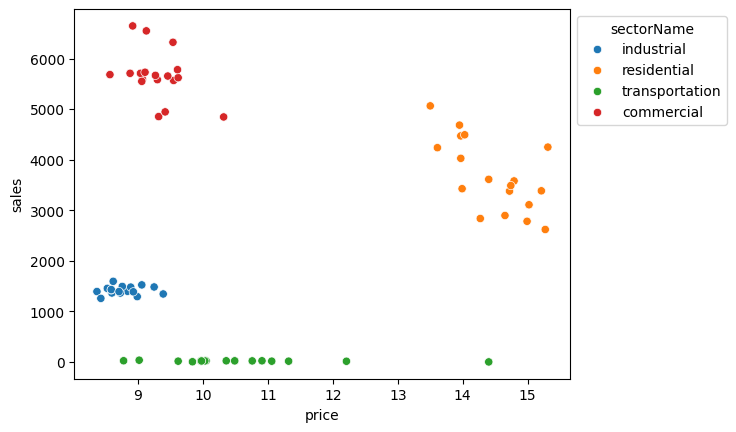

In [ ]:
this_plot = sns.scatterplot(x='price',y='sales',hue='sectorName',data=df)
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1))

## Without Labels:
- If the sector information is wiped away, some patterns still remain:

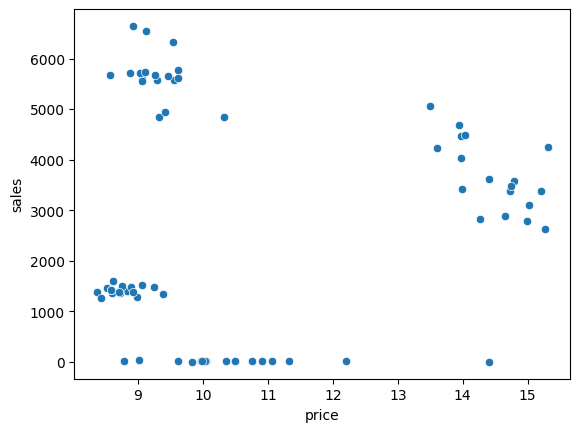

In [ ]:
this_plot = sns.scatterplot(x='price',y='sales',data=df)

## Unsupervised Learning
- Basically: "Can we recover the labels by examining the data, without knowing which group a point belongs to?"
- This is a conceptually simple problem, but it is a prototype for more general issues in recovering unobserved heterogeneity among observational units
- We'll be motivated by a simple idea, similar to $k$-NN: "If two points were created by the same data generating process/cluster, then their values are probably close together. If there are a discrete number of distinct data generating processes, we should be able to recover  their values by looking at separation between the groups."



---


Figure it out homie, give it your best let me just sit here and watch

---



## $k$-Means Clustering Algorithm ($k$-MC)
- The $k$-Means Clustering algorithm is:

  0. (Initialization) Randomly select $k$ points to be the *centroids*, $\{c_1, c_2, ..., c_k\}$
  1. Find the distance of each observation $x_i$ to each centroid $c_j$
  2. Assign each point $i$ to the closest centroid $j$
  3. Compute the new value of each centroid $j$ as the average of all of the observations $i$ assigned to it
  4. (Convergence) Repeat steps 1--3 until the observations are assigned to the same centroids twice, or a maximum number of iterations is reached

- $k$-MC is one of many clustering algorithms. What is nice about it is that, despite it being computationally intensive to calculate all these distances, it does scale to very large datasets. Likewise, a lot of the steps in using $k$-MC appear in other, similar algorithms (e.g. scree plot for spectral clustering)
- The next set of code chunks illustrate the algorithm for us

In [ ]:
from sklearn.cluster import KMeans # Import kmc

# Max-min scaler function:
def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Create normalizations and add to the dataframe
df['x1'] = maxmin(df['price'])
df['x2'] = maxmin(df['sales'])
min_x1 = min(df.loc[:,'price'])
max_x1 = max(df.loc[:,'price'])
min_x2 = min(df.loc[:,'sales'])
max_x2 = max(df.loc[:,'sales'])

# Preprocess the data for scikit:
X = df.loc[ : , ['x1','x2'] ] # Select data to cluster
X.head()

,x1,x2
0,0.067723,0.210339
2,1.000000,0.639332
4,0.180115,0.002274
5,0.168588,0.951309
6,0.056196,0.224621


Text(0.5, 1.0, 'The Data')

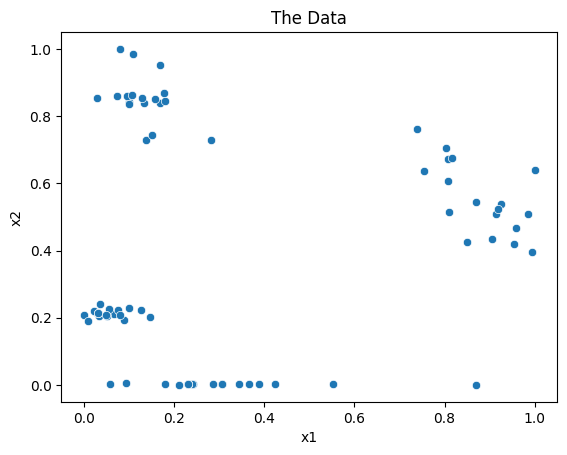

In [ ]:
sns.scatterplot(data=df,x='x1',y='x2').set_title('The Data') # Plot the fake data

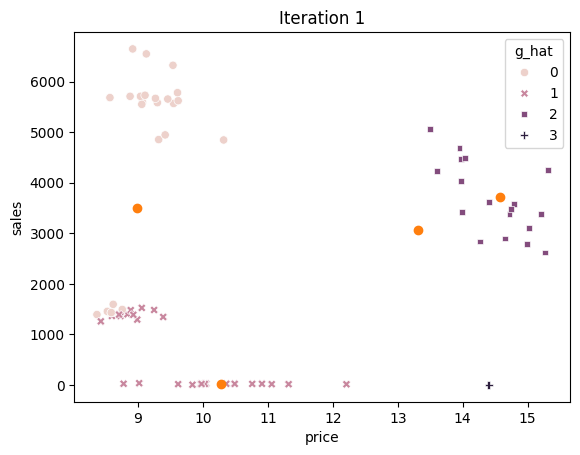

In [ ]:
#np.random.seed(100) # Does not work
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=1,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 1')
plt.scatter( centroid_x_1, centroid_x_2)

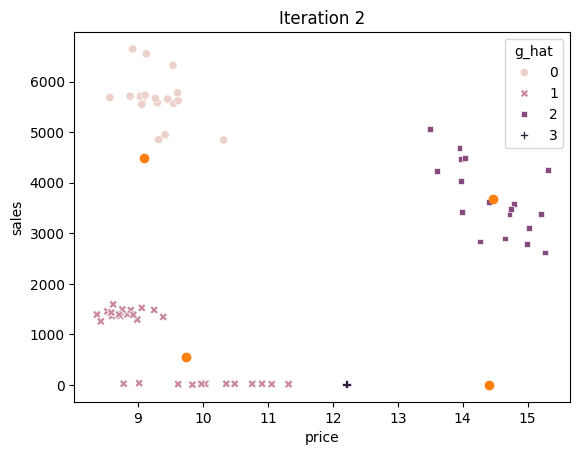

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=2,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 2')
plt.scatter( centroid_x_1, centroid_x_2)

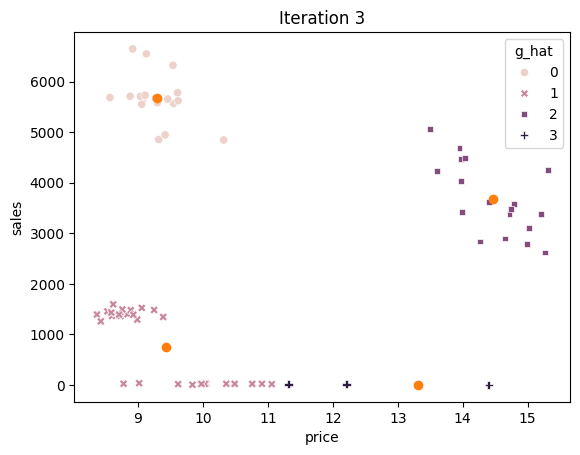

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=3,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 3')
plt.scatter( centroid_x_1, centroid_x_2)

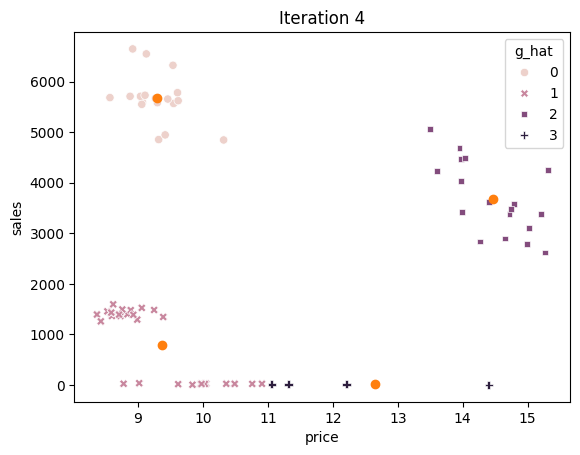

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=4,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 4')
plt.scatter( centroid_x_1, centroid_x_2)

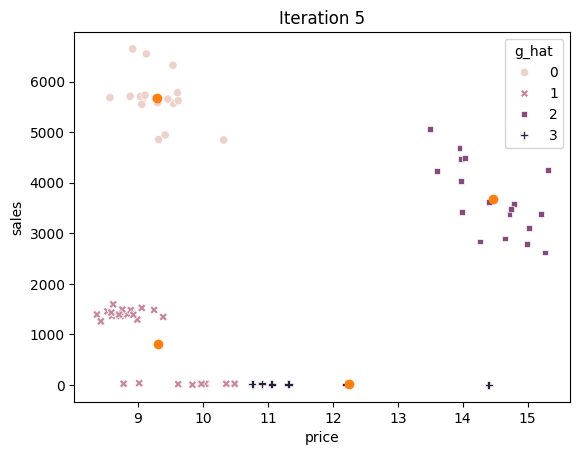

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=5,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 5')
plt.scatter( centroid_x_1, centroid_x_2)

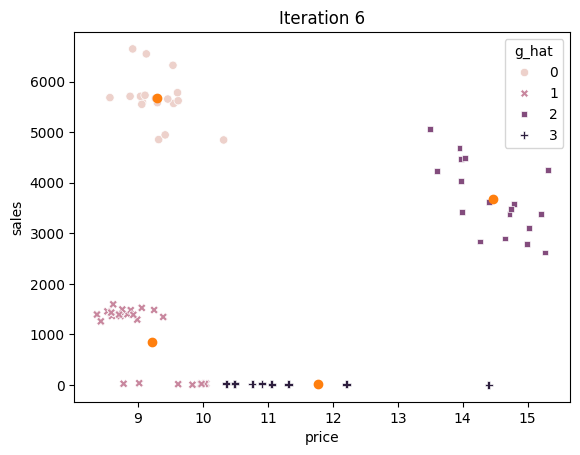

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=6,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 6')
plt.scatter( centroid_x_1, centroid_x_2)

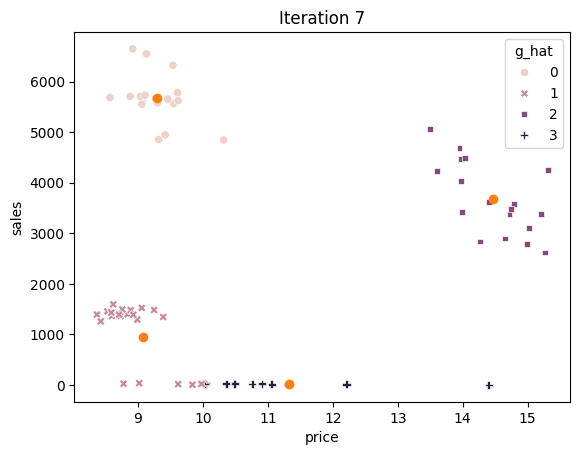

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=7,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 7')
plt.scatter( centroid_x_1, centroid_x_2)

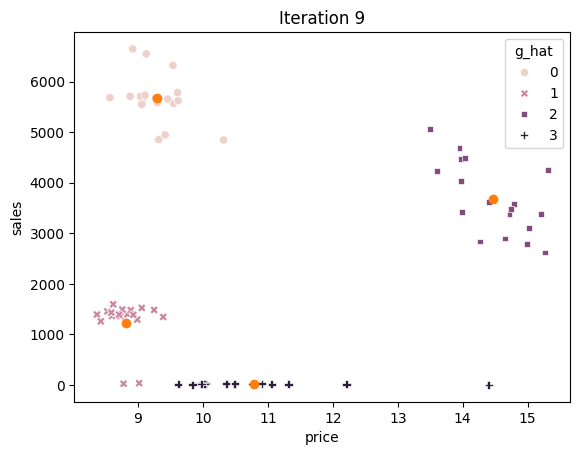

In [ ]:
np.random.seed(10)
initial_centroids = np.random.randint(low=1,high=X.shape[0],size=4) # Determine initial centroids
model = KMeans(n_clusters=4, max_iter=9,
               init = X.iloc[initial_centroids,:],random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 9')
plt.scatter( centroid_x_1, centroid_x_2)

## Distance and Scaling
- As with $k$NN, we typically mean Euclidean distance between our new case $\hat{x}$ and each observable $x_i$:
$$ d(\hat{x},x_i) = \sqrt{ \sum_{\ell=1}^N (\hat{x}_i - x_i)^2} $$
- We also need to scale the variables, since the distance metric we're using is relatively arbitrary. We typically use maxmin to rescale a vector $x = (x_1, x_2, ..., x_N)$:
$$ u_i = \dfrac{x - \min(x_i)}{\max(x)-\min(x)} $$
to ensure all of the dimensions are roughly comparable in magnitude
- There are dozens of variations on these pieces to be more data-driven or reconceptualize "distance" to be more appropriate for the current application



---


What happened when we did k nearest neighbor and didn't normalize? shit looked very strange...


---



## SciKit
- There's a canned version of $k$ Means Clustering that can easily be imported:
    - `from sklearn.cluster import KMeans`
- Key arguments with preset values:
    1. `n_clusters = 3`: Number of clusters
    2. `n_init = 10`: How many test runs
    3. `max_iter = 300`: Maximum number of iterations of the $k$MC algorithm; how many times to start from step zero?
    4. `random_state = None`: An initial state for the random number generator for replicability
- To create and fit a $k$-MC model, you:
    1. Use `model = KMeans(n_clusters,n_init)` to create the model
    2. Use the `.fit(X)` method to fit the model to the data $X$
    3. Use the `.predict(X_hat)` method to predict cluster values for new cases `X_hat`

## Example
- With these example data, only two points gets misclassified: The transportation sector points on the bottom left of the plot
- This obviously depends on how well the data are "separated": If the groups aren't reasonably visually distinct, the algorithm is unlikely to magically fix that problem (but it might help a lot in higher dimensional situations, where you have trouble visualizing the groups)

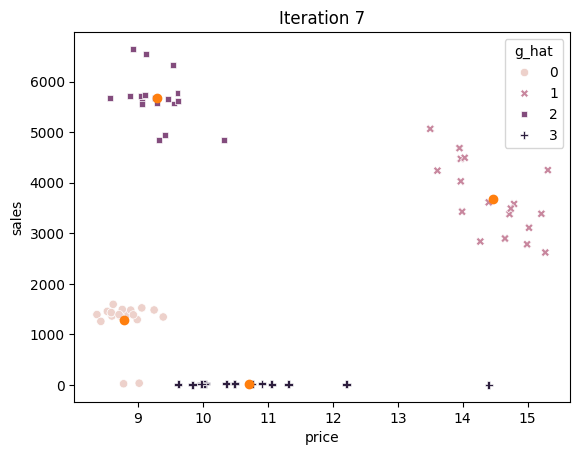

In [ ]:
model = KMeans(n_clusters=4,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('Iteration 7')
plt.scatter( centroid_x_1, centroid_x_2)

## Greedy Algorithms
- This is an example of a *greedy algorithm*
- When you assign observations to clusters/centroids, you are ignoring the consequences of changing the centroid averages for overall optimality
- Because you're ignoring the consequences of changing the centroid averages, the optimal assignment might change
- This process might never converge, and just run endlessly, with points meaninglessly wandering back and forth between centroids
- In general, there is no guarantee a stable assignment of observations to centroids exists
- The algorithm is greedy because it is short-sighted about the consequences of its actions, and need not converge to an optimal outcome (some algorithms do achieve optimality, despite being greedy)
- The non-greedy version of $k$-means clustering is arguably something called the **EM Algorithm** for imputing missing data, or a Gaussian Mixture Model (GMM)


## Adjusting $k$
- Typically, you don't want to have "too many clusters"
- For me, "too many clusters" means that many initial guesses give similar results in terms of minimizing error, but the cluster assignments change a lot across these minimizers: "Too many clusters" means that the assignment is somewhat arbitrary, which defeats the point of the algorithm in some sense

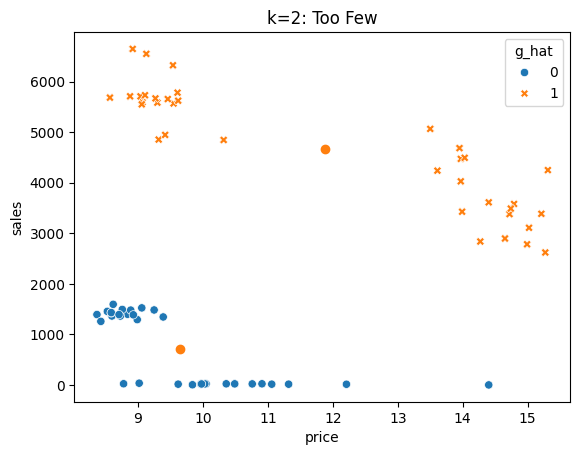

In [ ]:
model = KMeans(n_clusters=2,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=2: Too Few')
plt.scatter( centroid_x_1, centroid_x_2)

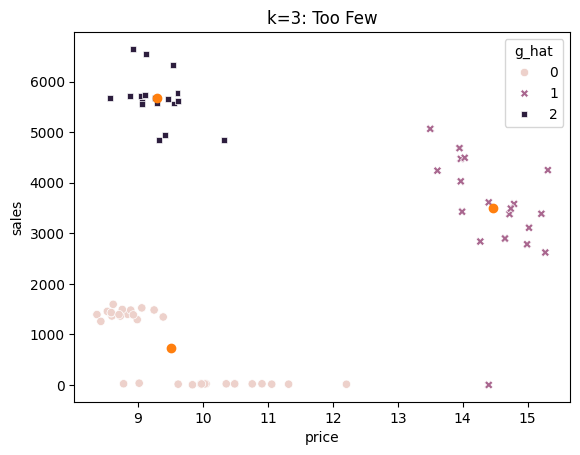

In [ ]:
model = KMeans(n_clusters=3,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=3: Too Few')
plt.scatter( centroid_x_1, centroid_x_2)

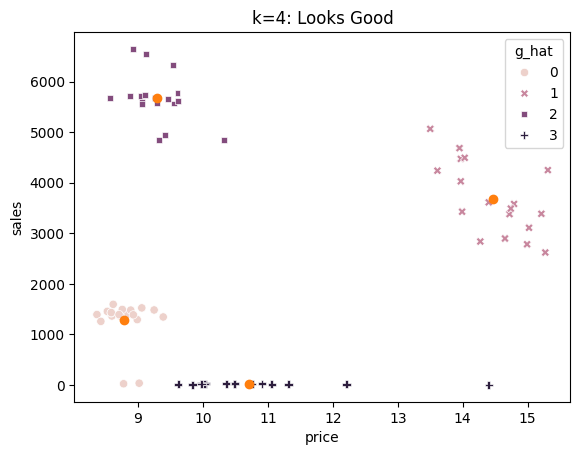

In [ ]:
model = KMeans(n_clusters=4,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=4: Looks Good')
plt.scatter( centroid_x_1, centroid_x_2)

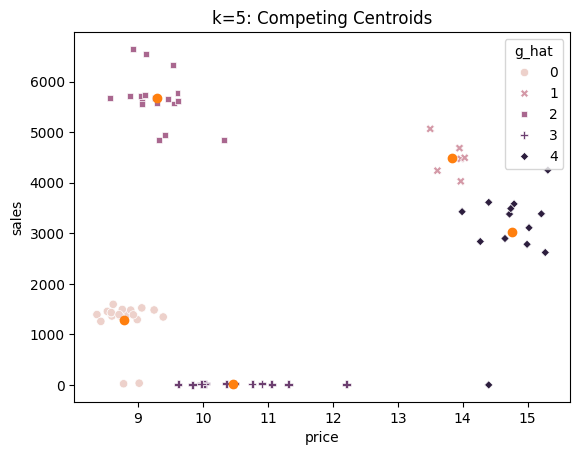

In [ ]:
model = KMeans(n_clusters=5,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=5: Competing Centroids')
plt.scatter( centroid_x_1, centroid_x_2)

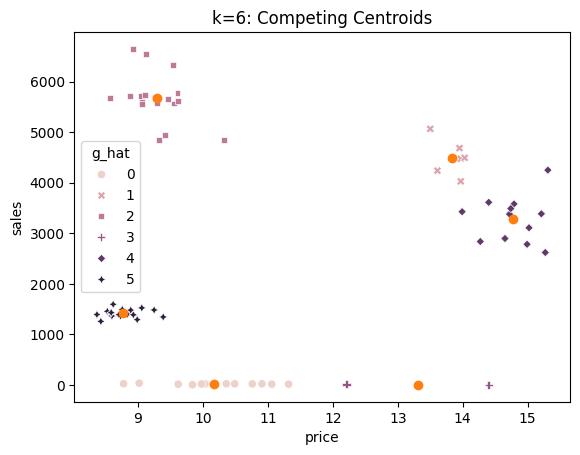

In [ ]:
model = KMeans(n_clusters=6,random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
df['g_hat'] = model.predict(X) # Predict values

# Re-normalize the centers, returning them to the scales of the original data, and plot:
centers = model.cluster_centers_ # Get the computed centers for the kmc model
centroid_x_1 = centers[:,0]*(max_x1-min_x1)+min_x1
centroid_x_2 = centers[:,1]*(max_x2-min_x2)+min_x2
this_plot = sns.scatterplot(data=df,x='price',y='sales',
                            hue='g_hat',style='g_hat').set_title('k=6: Competing Centroids')
plt.scatter( centroid_x_1, centroid_x_2)


## Picking $k$
- The number of clusters $k$ is another hyper-parameter: Picking a higher $k$ will break the data up more and reduce the in-sample error, making it tempting to always add more clusters. Here's how most people handle this:
    1. For a range of reasonable values of $k$, compute the optimal centroids and the sum of squared error
    2. Create a **scree plot** that plots SSE as a function of $k$
    3. Pick a $k$ that strikes a balance between reducing the error but introducing too many clusters (an "elbow point"): The reduction in SSE of going from $k-1$ to $k$ clusters is much larger than going from $k$ to $k+1$ clusters



---

How to get k to minimize error? technivally give every data point its won cluster --> but this isn't really a real model.

If we want to actually make a model we need ot use stats :((((((



---



## Sum of Squared Error
- Fix $k$, and focus on the solution to the clustering problem
- Every cluster $j$ has a centroid $c_j$, and the distance from each observation $x_i$ to the centroid to which it is assigned is $d(x_i,c_j)$
- The *within cluster squared error* is
$$
W_j = \sum_{\text{All observations } i \text{ in cluster } j} d(x_i,c_j)^2,
$$
and the *sum of squared error* (SSE) is
$$
\sum_{\text{All clusters j}} W_j = \sum_{\text{All clusters j}} \quad \sum_{\text{All observations } i \text{ in cluster } j} d(x_i,c_j)^2
$$
- This is a traditional metric of how well the model "fits" the data we'll come back to frequently
- In principle, $k$MC is trying to minimize this, but it's a greedy algorithm, so doesn't always achieve the global minimum SSE
- In scikit, this is the  `.inertia_` attribute of a fitted model.
    - Dot what? Yeah, I know... I didn't pick it...

Sum of within errors in SciKit is called .interia_, sorry it is wacky

## The Scree Plot
- If we plot $SSE(k)$ against the number of clusters $k$, we can see how the addition or subtraction of a cluster affects this measure of overall fit
- This is called a **scree plot**, and we can use it to decide on a particular number of clusters $k$

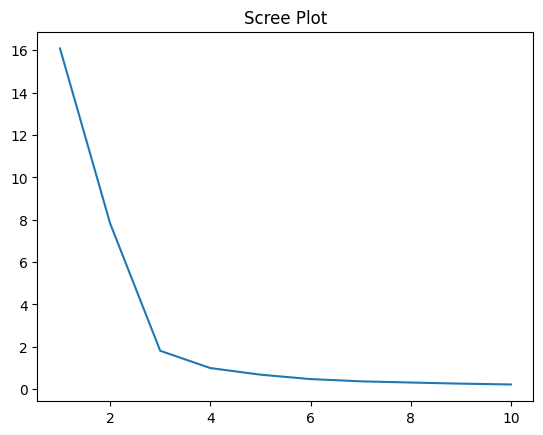

In [ ]:
from sklearn.cluster import KMeans # Import kmc

def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Create a scree plot:
k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for j in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k_grid[j], max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[j] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot') # Create scree plot

## Elbows
- To decide on an optimal $k^*$, people look for a spot where the reduction in $SSE$ of going from $k-1$ to $k$ drops significantly compared from $k$ to $k+1$
- This means the *marginal benefit* of an additional cluster is small, and increasing $k$ further is probably not really improving the fit
- If there's no elbow, either
    1. There aren't really any discrete clusters, and you're approximating a continuous trend with the groups
    2. Maybe there are discrete clusters, but you need to do more feature engineering/transformations, like Principal Components Analysis, or use use a different algorithm/metric of error size (e.g. silhouette and gap statistic)
- In our electricity example, if you went entirely data driven, you'd lump Industrial and Transportation into one second. Maybe that's OK.
- This feels very subjective, and there are other, more quantitative approaches to this (e.g. silhouette, gap)

## Hierarchical Clustering
- One easy and useful alternative to $k$-MC is **Hierarchical Clustering** or **Agglomerative Clustering**:
    0. All observations start in their own cluster
    1. Find the two "closest" clusters and merge them into a new cluster (this is conceptually a challenge, since the idea of "closest" becomes ambiguous when thinking about sets of points)
    2. Repeat until only one cluster remains
- This typically yields a more stable clustering scheme, but is much more computationally intensive

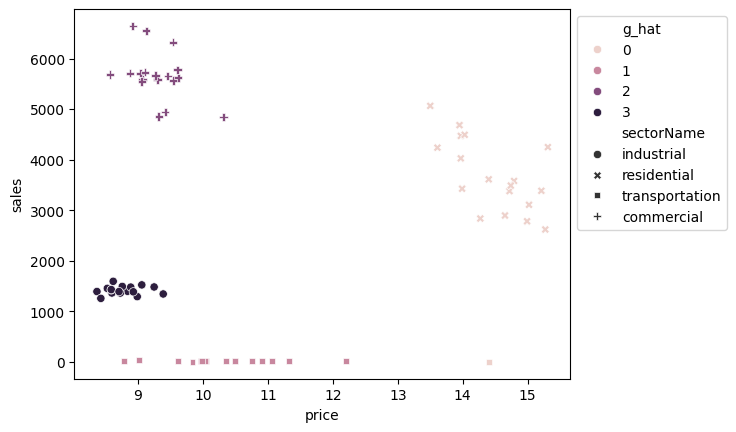

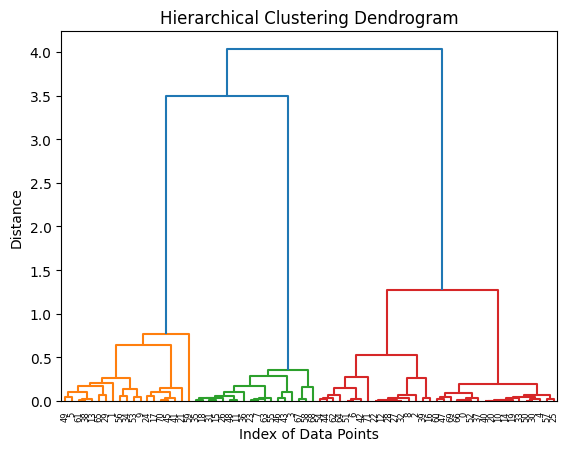

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
model.fit(X)
df['g_hat'] = model.labels_
this_plot = sns.scatterplot(x='price',y='sales',data=df, hue='g_hat',style='sectorName')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1))

# Plot dendrogram
plt.figure()
Z = linkage(X, 'ward')
dendrogram(Z,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index of Data Points')
plt.ylabel('Distance')
plt.show()



## Loose Ends
- Clustering in many dimensions (say, greater than 5) is risky: When the number of dimensions gets larger, many dimensions probably contain similar information, and the redundant information gets over-weighted in the algorithm
    - In high dimensions, you'll want to use something called **Principal Components Analysis** to remove the common information from the features
- There are other versions (spectral, dbscan, OPTICS, Mahalanobis) that fix various shortcomings of $k$-MC, but they are typically much more complex and computationally expensive
- Clustering is usually a mean to an end: The clustering is to push the data to reveal some latent group structure, and then that latent group structure enters into some other analysis

## Examples
- Before we get started on examples, the examples with $k$-MC often dissappoint me because I am expecting too much
    - Congressional Fundraising
    - Military Spending by Nation
    - Electricity Access
    - Patents by Country
    - Crime Statistics by State
    - International mental health